In [17]:
import os
import warnings
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from dotenv import load_dotenv
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans

In [18]:
# Warning 무시
warnings.filterwarnings('ignore', category=UserWarning)

# Seaborn 테마 설정
sns.set_theme(style='whitegrid')

# matplotlib 한글 폰트 설정
os.system('rm -rf ~/.cache/matplotlib')
os.system('fc-cache -fv')

plt.rc('font', family='NanumBarunGothic')
plt.rcParams['axes.unicode_minus'] = False

# 데이터 병합

In [19]:
# 데이터 로드
join_df1 = pd.read_csv('../data/ml_df_join.csv', index_col=0)
join_df2 = pd.read_csv('../data/ml_df_rent_fix.csv', index_col=0)

# 데이터 병합
merge_df = pd.merge(join_df1, join_df2, left_on='상권', right_on='상권')
data = merge_df.dropna()

# 2024년에 대한 칼럼 제거
data = data.loc[:, ~data.columns.str.startswith("2024")]
data.shape

(1377, 2397)

## 스케일링

In [20]:
selected_columns = data.iloc[:, 10:].copy()  # 기존 데이터 복사
additional_columns = data[['x좌표', 'y좌표']]  # 추가할 컬럼 선택

# 📌 새로운 데이터프레임 생성
data1 = pd.concat([selected_columns, additional_columns], axis=1)
scaler = StandardScaler()
scaled_data = scaler.fit_transform(data1)  # 표준화 적용
scaled_data = pd.DataFrame(scaled_data, columns=data1.columns)  # DataFrame 변환
scaled_data.shape

(1377, 2389)

# PCA

In [21]:
# 분기 리스트 생성
quarters = [f"{year}{q}" for year in range(2019, 2024) for q in range(1, 5)]

# 결과 저장 딕셔너리
pca_results = {}
loading_results = {}
variance_results = {}

# 분기별로 PCA 수행
for quarter in quarters:
  # 해당 분기에 해당하는 컬럼 선택
  selected_columns = [col for col in scaled_data.columns if col.startswith(quarter)]

  if not selected_columns:  # 해당 분기의 데이터가 없으면 건너뛰기
    continue

  # 데이터 선택
  X = scaled_data[selected_columns]

  # PCA 수행
  pca = PCA()
  X_pca = pca.fit_transform(X)

  # 설명된 분산 비율 계산
  explained_variance_ratio = np.cumsum(pca.explained_variance_ratio_)  # 누적 분산 비율 계산

  # 0.85를 넘는 최소 PC 개수 찾기
  num_components = np.argmax(explained_variance_ratio >= 0.85) + 1

  # 선택된 PC별 설명된 분산 비율 저장
  df_variance = pd.DataFrame({
      "PC": [f"PC{i+1}" for i in range(num_components)],
      "Explained_Variance": pca.explained_variance_ratio_[:num_components]
  })

  # 결과 저장
  variance_results[f"df_variance_{quarter}"] = df_variance

  # 선택된 PC들만 사용하여 새로운 데이터프레임 생성
  df_pca = pd.DataFrame(X_pca[:, :num_components], columns=[f"PC{i+1}" for i in range(num_components)])

  # 결과 저장
  pca_results[f"df_pca_{quarter}"] = df_pca

  # 📌 **각 분기의 로딩값(주성분 계수) 구하기**
  loading_matrix = pca.components_[:num_components].T * np.sqrt(pca.explained_variance_[:num_components])

  # 로딩값 데이터프레임 생성 (컬럼명은 PC1, PC2, ..., 인덱스는 원본 데이터의 컬럼)
  df_loading = pd.DataFrame(loading_matrix, index=selected_columns, columns=[f"PC{i+1}_loading" for i in range(num_components)])

  # 로딩값 결과 저장
  loading_results[f"df_loading_{quarter}"] = df_loading

# 딕셔너리에 저장된 데이터프레임을 개별 변수로 생성
globals().update(pca_results)
globals().update(loading_results)
globals().update(variance_results)

## 매출에 대한 우선분석에 대한 근거 확인
- PC1에서 매출에 해당하는 변수개수를 확인후 출력


In [22]:
# 매출에 대한 우선분석에 대한 근거 확인
# PC1에서 매출에 해당하는 변수개수를 확인후 출력

df_list = []

for year in range(2019, 2024):
  for quart in range(1, 5):
    df_name = f"df_loading_{year}{quarter}"
    if df_name in globals():
      df = globals()[df_name].copy()
      df = df.set_index(df.columns[0])
      df["Period"] = f"{year}Q{quarter}"
      df_list.append(df)

# 최대 20개 행을 유지하는 빈 데이터프레임 생성
total_df = pd.DataFrame(index=range(20))

for year in range(2019, 2024):
  for quarter in range(1, 5):
    df_name = f"df_loading_{year}{quarter}"

    if df_name in globals():  # 존재하는 데이터프레임만 처리
      df = globals()[df_name].copy().sort_values(by='PC1_loading', ascending=False)
      df = df.reset_index().head(20)  # 상위 20개 행 선택

      col_name = f"{year}{quarter}_PC1"  # 컬럼명 지정

      # 기존 total_df 크기를 유지하면서 새로운 컬럼 추가
      total_df[col_name] = pd.Series(df['index'].values[:20], index=range(20))

# 각 칼럼에서 "점포"라는 단어가 포함된 셀 개수 카운트
store_counts = total_df.apply(lambda col: col.astype(str).str.contains("매출").sum())

findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Fo

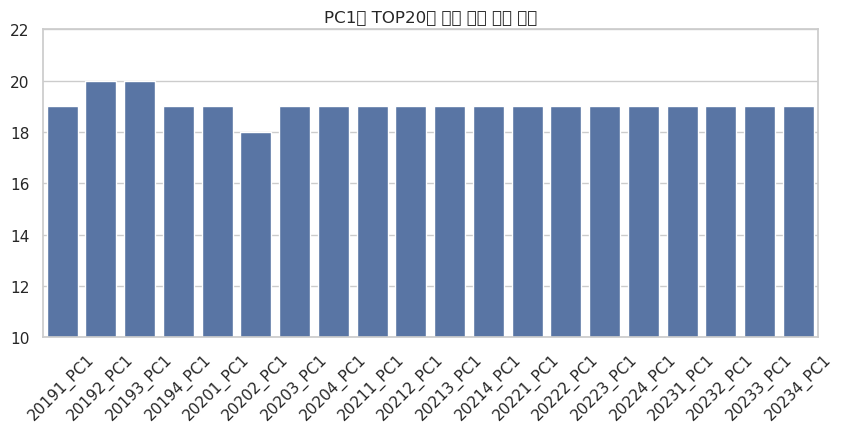

In [23]:
# 한번 이쁘게 시각화
plt.figure(figsize=(10, 4))
sns.barplot(store_counts)
plt.xticks(rotation=45)
plt.title('PC1별 TOP20의 매출 관련 변수 개수')
plt.ylim((10, 22))
plt.show()

# 군집분석
## k-means

In [24]:
# 클러스터링 결과 저장 딕셔너리
final_cluster_results = {}

# globals()에서 df_pca_* 형태의 데이터프레임 찾기
pca_dfs = {key: value for key, value in globals().items() if key.startswith("df_pca_")}

# 각 df_pca_{quarter}에 대해 KMeans 클러스터링 수행 (K=3 고정)
for quarter, df_pca in pca_dfs.items():
  if df_pca.empty:  # 데이터가 비어 있는 경우 스킵
    print(f"{quarter} 데이터가 비어 있음. 건너뜀.")
    continue

  # print(f"{quarter} - PCA 데이터 크기: {df_pca.shape}")

  #  NaN이 있으면 제거
  if df_pca.isna().sum().sum() > 0:
    print(f"{quarter}: NaN 값이 존재. 제거 후 진행.")
    df_pca = df_pca.dropna()

  if df_pca.shape[0] < 3:  # 최소 3개 샘플 이상 필요
    print(f"{quarter}: 데이터가 너무 적어 KMeans 수행 불가. 건너뜀.")
    continue

  # K=3으로 KMeans 클러스터링 수행
  kmeans = KMeans(n_clusters=4, random_state=42, n_init=10)
  cluster_labels = kmeans.fit_predict(df_pca)

  # 클러스터링 결과 데이터프레임 생성
  df_cluster = df_pca.copy()
  df_cluster["Cluster"] = cluster_labels

  # "df_pca_"를 제거한 올바른 데이터프레임 이름 생성
  quarter_name = quarter.replace("df_pca_", "")
  final_cluster_results[f"df_4cluster_{quarter_name}"] = df_cluster

In [25]:
# final_cluster_results에 저장된 데이터프레임을 개별 변수로 생성
for name, df in final_cluster_results.items():
  globals()[name] = df

# 저장된 데이터프레임 목록 확인
print("생성된 개별 데이터프레임 목록:", list(final_cluster_results.keys()))

생성된 개별 데이터프레임 목록: ['df_4cluster_20191', 'df_4cluster_20192', 'df_4cluster_20193', 'df_4cluster_20194', 'df_4cluster_20201', 'df_4cluster_20202', 'df_4cluster_20203', 'df_4cluster_20204', 'df_4cluster_20211', 'df_4cluster_20212', 'df_4cluster_20213', 'df_4cluster_20214', 'df_4cluster_20221', 'df_4cluster_20222', 'df_4cluster_20223', 'df_4cluster_20224', 'df_4cluster_20231', 'df_4cluster_20232', 'df_4cluster_20233', 'df_4cluster_20234']


In [26]:
# 각 데이터 프레임의 각 상권의 칼럼 붙여주기
for year in range(2019, 2024):
  for quart in range(1, 5):
    quarter_key = f'df_4cluster_{year}{quart}'
    cluster_df = globals()[quarter_key].copy()

    # data['상권'] 컬럼 추가
    cluster_df['상권'] = data['상권']

    # 새로운 변수명으로 저장
    new_key = f'cluster_df_{year}{quart}'
    globals()[new_key] = cluster_df

In [27]:
cluster_df_20191

,PC1,PC2,PC3,PC4,Cluster,상권
0,-0.676738,3.134349,-0.529508,-0.822720,0,배화여자대학교(박노수미술관)
1,-0.540788,-0.766346,-0.242808,1.280549,1,세종마을음식문화거리(금천교시장)
2,-2.656878,-1.959457,-0.076684,0.203376,1,통인시장
3,-2.957838,-1.373154,0.118826,0.053731,1,동묘시장(동묘벼룩시장)
4,2.606929,-2.581391,-2.684357,0.627921,1,동대문문구완구거리(동대문문구완구시장)
...,...,...,...,...,...,...
1372,-3.494871,-1.856278,0.347977,-0.030590,1,언북초등학교
1373,-3.550110,-1.871832,0.137295,0.148438,1,NaN
1374,-2.216806,-2.746278,-0.176935,0.835878,1,언주중학교
1375,-3.012576,-1.764277,-0.056877,0.172801,1,언주역 6번


# 진짜 시작

## 클러스터 군집 확인이 필요
1. 클러스터별 비율이 같은거는 거의 확인이 끝남.
2. 각 클러스터를 비율별로 옮기기
3. df4cluster_{year}{quart} <- 이런식으로 변수가 되어있음

In [33]:
# 빈 데이터프레임 초기화
total_df = pd.DataFrame()

file_name = list(final_cluster_results.keys())

# 파일 불러오기
for file in file_name:
  cluster_df = globals()[file]

  # 클러스터 변환 작업 그대로
  chnage_cluster = pd.DataFrame(cluster_df['Cluster'].value_counts())
  chnage_cluster = chnage_cluster.sort_values(by='count')
  join_cluster = chnage_cluster.reset_index().reset_index()[['index', 'Cluster']]
  final_df = pd.merge(cluster_df, join_cluster, left_on='Cluster', right_on='Cluster').drop('Cluster', axis=1).rename(columns={'index': 'cluster'})

  final_df = final_df[['cluster']]
  final_df.columns = [f'{file[-5:]}_cluster']
  total_df = pd.concat([total_df, final_df], axis=1)

  # 필드명 조인
total_df['상권'] = data['상권']
total_df

total_df.to_csv('../data/cluster_difference.csv')